# Python's Next Top Model
By The Good, The Bad and the Ugly aka. The Three Musketeers.

In [2]:
# Importing packages
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np
import itertools
from ipywidgets import Layout
import math

import time
from scipy import linalg
import scipy.optimize as optimize
import sympy as sm
#from data_gen import gen_df 
from IPython.display import clear_output 

Welcome back to the wonderful Python universe of Credible Threats. We will continue the exploration of movies, and we're sure that our data project notebook will look at this notebook and think, *you complete me*. You might want to ask, *Magic mirror on the wall, who's the fairest one of all*, and the answer will be this notebook. This notebook will try to estimate the IMDb ratings of movies. And as a bonus, we even have a live-updating figure, which will leave you thinking, *it's alive, it's alive*. 

We will calculate the utility of each movie, given genres, awards, duration and so forth, and we will try to calculate the IMDb ratings for each movie, based on this utility. Finally, we will minimize the distance between our estimated ratings and the actual IMDb ratings. Now, we're sure you're thinking, *show me the money*, so this is it. 

Our utility function is given by: 
$$ U_i = \sum_{k=1}^{23}(\alpha_k G_{ik}) + \sum_{k=1920}^{2010} (\beta_k D_{ik}) + \gamma N_i + \delta W_i + \rho L_i $$. 

$$\text{Where, } G_{ik} \text{ is genre } k \text{, } D_{ik} \text{ is decade } k \text{, } N_i \text{ is award nominations, } W_i \text{ is award wins, and } L_i \text{ is duration. } $$ 

I think we can agree, it is *beauty kills the beast*. 
Now, based on this utility function, we will estimate the ratings of each movies,
$$ R_i^{model} = \frac{\exp(\omega x_i')}{1 + \exp(\omega x_i')} $$ 

where, 
$$ x_i = \big[G_1, G_2, ..., G_{23}, D_{1920}, D_{1930}, ..., D_{2010}, N_i, W_i, L_i \big] $$
$$ \omega = \big[\alpha_1, \alpha_2, ..., \alpha_{23}, \beta_{1920}, \beta_{1930}, ..., \beta_{2010}, \gamma, \delta, \rho_1 \big] $$

We then use optimize methods to solve the following: 
$$ \min_{\omega} \Big\{ \sum_{i=1}^{n} \left( R_i^{model} - R_i^{data} \right)^2 \Big\} $$

$$ \text{where, } R_i^{data} \text{ are the true IMDb ratings from the dataset, and} R_i^{model} \text{are the ratings calculated from the utility function.}$$

Throughout our notebook, you might *feel the need - the need for speed*. But, *patience you must have, my young Padawan*, because optimizing takes time. 

*Of all the python notebooks in all the towns in all the world, you walk into ours*. How lucky you are, you'll soon see why. 

So, *say hello to my little friend*, Python's next top model.  
Let's *get busy coding, or get busy dying*. 

![test](https://media.giphy.com/media/LpkBAUDg53FI8xLmg1/giphy.gif)


In [3]:
# List for later use 
variables = ['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
            'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
            'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
            'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
            'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
            'nrOfNominations','nrOfWins','duration']

vars_dec = ['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
        'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
        'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
        'nrOfNominations','nrOfWins','duration']

decade_list = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]


# Function to calculate squared mean differences 
def sqr_diff_sum(df_X,pars):
    """ Generates a float of the sum of squared differences between the ratings from the data and the model. 

    Args: 
        df_X (DataFrame): DataFrame containing the variable in x for all observations.
        pars (List): List of parameters in omega

    Returns: 
        A float.
    """
    # Calculate the matrix product between omega and X
    util = df_X@pars  
    # Scale the product so it's between 0 and 10. This is the R_model
    df_Y['rat_model'] = 10*np.exp(util)/(1+np.exp(util)) 
    # Calculate the squared difference between R_data and R_model
    df_Y['sqr_diff'] = (df_Y['rat_model']-df_Y['rat_data'])**2 

    return df_Y['sqr_diff'].sum() # Returns the sum of the squared differences

In [4]:
def gen_df(filename):

    # Get .csv.file
    data = pd.read_csv(filename, sep=';', encoding='latin-1', escapechar='\\')

    # Read file into pandas dataframe
    df = pd.DataFrame(data)

    # Drop unwanted columns
    for i in range(44,48):
        df.drop(columns=[f'Unnamed: {i}'], inplace=True)

    # Filters out movies with less than 5000 ratings and drops some genres and other columns
    df = df.loc[(df['ratingCount']>=5000)]
    df.drop(columns=['fn','wordsInTitle','url','Adult','GameShow','News','RealityTV','TalkShow'], inplace=True)

    # Keep only observations of movie-type
    I = df['type'] == 'video.movie'
    df = df.loc[I]
    df.drop(columns=['type'], inplace=True)

    # Drop observations with missing data
    df.dropna(inplace=True)

    # Replace 0's in imdb-ratings
    df['imdbRating'] = df['imdbRating'].astype(str)
    df['imdbRating'].replace(regex=True, inplace=True,to_replace='0',value='')
    df['imdbRating'] = df['imdbRating'].astype(float)

    # Transform duration from seconds to hours
    df['duration'] = df['duration']/60**2

    # Drop years before 1920 and 2014 because of few obervations
    I = (df['year']>=1920) & (df['year']<=2013)
    df = df.loc[I]

    # Change the type of 'year' to integer
    df['year'] = df['year'].astype(int)    
    
    # Sort observations and reset index
    df.sort_values('year', inplace=True)
    df.reset_index(inplace=True)


    # Generating variable that shows the decade (as a string)
    year_list = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

    df['decade'] = ''
    for i,start in enumerate(year_list):
        end = start+10
        df.loc[(df['year'] >= start) & (df['year'] < end), 'decade'] = f'{year_list[i]}s'

    return df

In [5]:
def df_s(keep_top=None, decade=None):
    """ Prepares data for optimization by creating dummmy-variables for decades, dropping movies with less than 5000 ratings,
        dropping some variables that we don't wish to use in the model, and splitting the dataset, so we have a data set
        consisting only of the variables used in the model.
        
    Args:
        keep_top (optional, type: int): When a number (n) is put in this option, only the top n movies a kept in the dataset. This is used to remove movies for a better fit of the model

    Returns:
        df_X (type: Pandas dataframe): A dataframe consisting only of the varaibles that are used to calculate the rating.
        df_Y (type: Pandas dataframe): A dataframe consisting of the true ratings from the dataset and an index-variable, used for merging with original dataset, later in the process.

    Notice:
        The function includes global for 'df', which means that the dataframe 'df' generated, can be called outside the function. This is used so that we won't have to filter the original dataframe everytime we use it.
    """
    global df

    # Calls the file 'imdb.csv' which is located in the repository, and contains the dataset used
    filename = 'imdb.csv'

    # A function generated earlier, which cleans the dataset [Should we include this, and do some of the filtering below in that funciton?]
    df = gen_df(filename)
            
    # Keeps only top n movies, if this is specified when calling the function
    if keep_top != None:
        df = df.sort_values('imdbRating', ascending=False)
        df = df.iloc[:keep_top]
    
    if decade == None:
        # Decade dummies
        for i in decade_list:
            df[f'decade_{i}'] = 0
            df.loc[(df['decade'] == f'{i}s'),f'decade_{i}'] = 1
        
        # Splits the dataset into two datasets
        df_X = df.copy()
        df_Y = pd.DataFrame(df[['imdbRating', 'index']].copy())
        df_Y = df_Y.rename(columns = {'imdbRating':'rat_data'})

        # Rearrange and keep given columns 
        df_X = df_X.reindex(['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                              'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                              'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                              'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
                              'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                              'nrOfNominations','nrOfWins','duration'], axis=1)
            
    
    if decade != None:
        # Keeps movies from the specified decade
        df = df.loc[df['decade'] == f'{decade}s'] 

        # Splits the dataset into two datasets
        df_X = df.copy()
        df_Y = pd.DataFrame(df[['imdbRating', 'index']].copy())
        df_Y = df_Y.rename(columns = {'imdbRating':'rat_data'})

        # Rearrange columns and keep the specified variables 
        df_X = df_X.reindex(['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                                  'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                                  'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                                  'nrOfNominations','nrOfWins','duration'], axis=1)


    return df_X, df_Y

## Optimization
We analyze preferences for movies by minimizing the sum of the squared differences from our model prediction and the true rating, i.e.:
$$ 
\min_{\omega} \Big\{ \sum_{i=1}^{n} \left( R_i^{model} - R_i^{data} \right)^2 \Big\} 
$$ 
By doing so, we'll find parameters that best describe movie preferences given our model. As we will discuss later, our model is not necessarily the best model to describe preferences, which might lead to these preferences not being accurate. <br>
If the model could predict all movie ratings correctly the parameters would perfectly describe movie preferences. For example if the parameter for action-movies were negative, the prediction would be precise, if action-movies generally had a negative impact on ratings. Of course people have much different preferences, and an interesting analysis would be, to predict preferences for different people, and by this look at a distribution of these parameters. This is not included in this project, though, mainly because of we don't have the data for it. <br>
To shorten the length of the optimizing process, and to sort out movies that makes it harder for the model to predict preferences, the optimization can be based on the top n movies, based on IMDb rating. When all movies are included in the optimizer the lowest ranking movies will have ratings around 2. Our rating predictor will in this case not rank any movies under 5. Thereby it is clear that the predictor model is not able to predict movies with very low rating. But it is able to predict movies with higher ratings.

In [9]:
def optimizer(keep_top=None, live_graph=True):
    """ Creates and optimizes the function which calculates rating based on variables in the dataset.
    
    Args:
        keep_top (optional, type: int): When a number (n) is put in this option, only the top n movies a kept in the dataset. This is used to sort out movies for a better fit of the model
        live_graph(optional, type: boolean): Produces a live graph of the optimization proces, plotting the function values against the iterations. Makes the optimizer slower, but is a good visualization of the process.
                                             
    Returns:
        result (type: scipy optimizer object): An object containing results from the optimizer among other information such as status etc.
        timer (type: int): Time of running optimizer in seconds.
                                               
    Notice:
        Uses the package scipy.optimize.minimize which optimizes functions based on a given method. Here 'Nelder-Mead' is used.
        This function defines a set of functions used in the optimizer which are not documented by docstring but comments in code.
    """
    # "Initializes" a timer for printing time of optimization
    start = time.time()
    
    # Set of globals, so variables can be called inside the functions defined in this function
    global fs
    global evals
    global x0
    global df
    global df_Y
        
    # Plots a live graph of optimization process, if chosen.
    if live_graph:
        # The live plot is created by taking the function value for each iteration and saving in a list
        def live_plot(evals, fs, ymax=10000, figsize=(7,5)):
            # Clears plot every time a new plot is created
            clear_output(wait=True)
            plt.figure(figsize=figsize)

            # Plots values and sets title, grid, labels, etc.
            plt.plot(evals, fs)
            plt.title('Figure 1: Optimizing path')
            plt.grid(True)
            plt.xlabel('Iterations')
            plt.ylabel('Function value')
            plt.xlim(0,17500)
            plt.ylim(0,ymax)

            plt.show();

    # Function to be called by optimizer each iteration. This returns function values for each iteration and plots live graph
    def collect(x):
        # Set of globals to be called in live graph-function
        global fs
        global evals
        global x0
        global fig
        global ax
        global ymax
        global x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20
        global x_21, x_22, x_23, x_24, x_25, x_26, x_27, x_28, x_29, x_30, x_31, x_32, x_33, x_34, x_35, x_36


        # Calculates function value for initial guess, for first iteration
        if evals == 0:
            fs = []
            fs.append(obj_fun(x0))
            # Generates vector of parameter estimates
            for i in range(1,37): # 1 to 36
                globals()[f'x_{i}'] = [x0[i-1]]

        # Calculates function values for current parameter values
        if evals != 0:
            fs.append(obj_fun(x))
        
        # Plots live graph if chosen
        if live_graph:
            # Calculates max y-value for axis for first iteration
            if evals == 1:
                ymax = math.ceil(obj_fun(x)/2000)*2000

            # Updates plot every 100th iteration for the first 1000 iterations
            if evals < 1000:
                if evals > 0 and evals%100 == 0:
                    live_plot(range(evals+1), fs, ymax)
            # Updates plot every 500th iteration for the rest of the process
            if evals >=1000:
                if evals%500 == 0:
                    live_plot(range(evals+1), fs, ymax)
        
        # Appends esimtates to x_vectors 
        for i in range(1,37):
            globals()[f'x_{i}'].append(x[i-1])

        # Adds one to the number of iterations each iteration
        evals += 1
    
    # Define datasets to be used using function defined earlier
    df_X, df_Y = df_s(keep_top=keep_top, decade=None)
    
    # Intiial guess
    x0 = np.zeros(len(variables))
    
    # Start iteration number
    evals = 0
    
    # Defines function to be minimized
    obj_fun = lambda x: sqr_diff_sum(df_X,x)
    
    # Run optimizer
    result = optimize.minimize(obj_fun,x0,
                               method="Nelder-Mead",
                               options={"disp":True, "maxiter":50000}, # display the results
                               callback=collect
                               ) 
    
    # End timer
    end = time.time()-start
    
    # Returns
    return result, end

By runing the code below you can see a live-updating graph that shows the value of the sum of the squared difference for each iteration. As you will see, the sqaured difference reaches close to its minimum very quickly so the last 10,000 iterations almost don't change the value of the squard difference. The live-graph slows the optimizer down, so choose option live_graph=False, if you are impacient and don't care about an awesome live-updating graph.

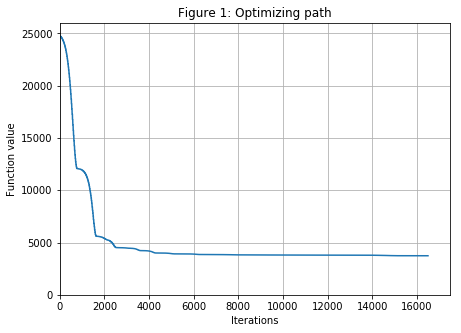

Optimization terminated successfully.
         Current function value: 3735.382286
         Iterations: 16566
         Function evaluations: 19203
         Time: 118.4200 seconds


In [10]:
# Run optimizer function and print results and time
result, timer = optimizer()
print(f'{" ":9s}Time: {timer:.4f} seconds')

# Keep copy of df and df_Y for later purpose
df_Y_all = df_Y.copy()
df_all = df.copy()

The following cell will give a list of the estimated parameters/preferences, and the cell after that produce a figure showing the path of the estimated parameters, i.e. the parameter estimate for each iteration. 

In [11]:
# List of Parameter Estimates 

# Constructs dictionary with parameters 
preben = dict()
for j,i in enumerate(variables):
    preben[i] = f'{result.x[j]:.2f}'


# Prints list of parameterestimes 
for i in preben: 
    print (i, ":", preben[i])


Action : -0.02
Adventure : -0.03
Animation : 0.17
Biography : -0.17
Comedy : -0.02
Crime : -0.03
Documentary : 0.11
Drama : 0.13
Family : -0.06
Fantasy : -0.33
FilmNoir : 0.02
History : -0.08
Horror : -0.02
Music : -0.03
Musical : -0.08
Mystery : -0.09
Romance : -0.04
SciFi : -0.10
Short : 0.12
Sport : -0.06
Thriller : -0.06
War : 0.19
Western : 0.03
decade_1920 : -0.04
decade_1930 : 0.12
decade_1940 : 0.18
decade_1950 : -0.03
decade_1960 : 0.31
decade_1970 : 0.10
decade_1980 : 0.01
decade_1990 : -0.22
decade_2000 : -0.20
decade_2010 : -0.21
nrOfNominations : 0.00
nrOfWins : 0.02
duration : 0.45


In [12]:
## Convergence of Parameter Estimates 

# Constructing dataframe which contains all parameter vectors as variables
par_dict = {"Action": x_1,
             "Adventure": x_2,
             "Animation": x_3,
             "Biography": x_4,
             "Comedy": x_5,
             "Crime": x_6,
             "Documentary": x_7,
             "Drama": x_8, 
             "Family": x_9,
             "Fantasy": x_10,
             "Film Noir": x_11,
             "History": x_12,
             "Horror": x_13,
             "Music": x_14,
             "Musical": x_15,
             "Mystery": x_16,
             "Romance": x_17,
             "SciFi": x_18, 
             "Short": x_19,
             "Sport": x_20,
             "Thriller": x_21,
             "War": x_22,
             "Western": x_23,
             "1920's": x_24,
             "1930's": x_25,
             "1940's": x_26,
             "1950's": x_27,
             "1960's": x_28,
             "1970's": x_29,
             "1980's": x_30,
             "1990's": x_31,
             "2000's": x_32,
             "2010's": x_33,
             "Nr. of Nominations": x_34, 
             "Nr. of Wins": x_35, 
             "Duration": x_36
            }

df_par = pd.DataFrame(par_dict)


##  Interactive graph of parametervalues for each iteration in optimizer 
# Chose which parameter to show 

# Interactive graph of parameter estimates
def graph(par):
    """
    Constructs a graph which shows the progress in parameter estimates foreach iteration in
    the optimizing process. 
    
    Args: 
        par (type: str): Variable name, for which the graphs shows the parameter estimates. 
                
    Returns: 
        Graph of progress in parameter estimates. 
        
    Notice: 
        The function is meant to be called within the graph_int function. 
        The graph_int function turns this graph into an interactive function, where the 
        user can choose between variables. 
        Thus, the graph is not meant to be run on its own. 
    """
    # Generating figure 
    plt.plot(df_par[par])
    
    # Grid and axes 
    plt.grid(True)
    plt.axhline(df_par[par].iloc[-1], linestyle="dashed", color="orange", label="Optimum")
    
    # Labels and Titles 
    plt.title("Figure 2: Progress in Parameter Estimation")
    plt.ylabel("Parameter Estimate")
    plt.xlabel("Nr. of Iterations")
    plt.legend()


# Interactive part: Choose between parameters 
def graph_int(): 
    """
    Constructs interactive graph from the graph function. 
    """
    widgets.interact(graph, 
                     par = widgets.Dropdown( 
                     description="Variable", 
                     options=df_par.columns.values, 
                     value="Action"));
graph_int()


interactive(children=(Dropdown(description='Variable', options=('Action', 'Adventure', 'Animation', 'Biography…

From the above figure, we notice that most parameter estimates are very volatile in the first 10,000-15,000 iterations, following which they converge towards the optimum value. 

However, this does not appear to be the case for the variables, Nr. of nominations and Nr. of awards, which get quite close to the optimum value at around the 7500th iteration. 
Additionally, we notice that the variable Duration appears to have the largest effect on ratings, which the optimzer seems to realize after approximately 2500 iterations. 

In the next part of the project we will plot the optimal estimates in a figure. Furthermore, we show how the estimates changes a lot when the sample size is restricted to only the best movies. 

In [14]:
## This piece of code solves the model for three different sample size

#### OBS: The code will take a couple of minutes to run because the model is solved three times!! ####

# List to store result for the optimization with the different sample sizes
results_list = [result.x]

# This loop solve the model for the top 500, 1000, and 2000 movies
for i in [500, 1000, 2000]:
    res_temp, timer_temp = optimizer(keep_top=i, live_graph=False)
    temp = res_temp.x
    print(f'{" ":9s}Time: {timer_temp:.4f} seconds')
    results_list.append(temp) # Store the results in the 'results_list'

Optimization terminated successfully.
         Current function value: 197.838633
         Iterations: 13628
         Function evaluations: 15779
         Time: 63.0919 seconds
Optimization terminated successfully.
         Current function value: 439.055453
         Iterations: 21224
         Function evaluations: 24448
         Time: 94.0714 seconds
Optimization terminated successfully.
         Current function value: 903.321786
         Iterations: 16176
         Function evaluations: 18626
         Time: 78.6587 seconds


In [15]:
## The code creates an interactive plot of the estimated parameters for all variables. 
## In the interactive part you can choose between estimates when the model is solved 
## for all movies or just top top 500, 1000, or 2000 rated movies. 

def fig_2(val):
    """ Generates a figure which plots estimated parameters for all variables.

    Args: 
        val (string or int): Should be one of the elements in the options-list

    Returns: 
        One interactive plot.  

    Notice: 
        The function is generated so that it can be called using widgets.interact. 
        Thus, it is not intended to be used on its own. 
    """   
    # Initiates figure
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1,1,1)
    
    # Plots the estimated parameters for the chosen sample of movies
    ax1.bar(variables, results_list[options.index(val)], label=f'Estimates with {options[options.index(val)]} movies')
    
    # Scatter plot with the estimated paramters for the entire sample 
    ax1.scatter(variables, results_list[0], marker='D', s=15, zorder=2, label='Estimates with all movies')
    
    # Legends and labels 
    ax1.legend(loc="lower right")
    ax1.set_ylabel('Parameter estimates')
    ax1.set_title(f'Figure 3: Parameter estimates for {options[options.index(val)]} movies')
    ax1.set_ylim([-0.7,0.7])
    ax1.axhline(y=0,color='black',linewidth=1)
    for tick in ax1.get_xticklabels():
        tick.set_rotation(90)
        
options = ['All', 500, 1000, 2000] # Option list

# Making the figure interactive so the estimates are shown for the chosen sample size 
widgets.interact(fig_2,
    val = widgets.Dropdown(description='Nr. of movies', value='All', options=options, 
                ),
);   

interactive(children=(Dropdown(description='Nr. of movies', options=('All', 500, 1000, 2000), value='All'), Ou…

As also showed in the list above, duration is the varaible that effects the ratings the most. This is also the case when the model is solved for top 500, 1000, and 2000 rated movies, cf. figure 3. However, it seems like duration is the only estimate which is fairly stable. The sign of the decade dummies is an example. When the model is solved for the entire sample, the estimates are positive for the older decade-dummies, i.e. the 1920s and 1930s, and negative for the newer decade-dummies, the 2000s and 2010s. However, when the sample only contains the top 2000 rated movies we see the opposite picture. We know from figure 10 in our dataproject that the ratings of the younger movies have a larger variance with more high-rated movies but also a lot of poorly rated movies. By restricting the sample to only the best movies we drop all the bad new movies, and this is probably the reason to the positive estimates of the newer movies. 

## Robustness checks

### Prediction precision
Ideally our model would predict movie ratings perfectly, and thereby our parameters would perfectly describe the general preferences for movies. Whether this is possible, even with an advanced model, is not sure. People have different preferences, and two movies that would seem identical in our dataset, based on genres, duration, time of release, etc. could have very different ratings. Therefore some devitaion in our prediction from the true ratings are expected. For that reason, this section will explore how well our model describe the actual ratings, and why some estimates are more reliable than others.

In [16]:
def merge_df(df_org):
    """ Merges the original dataset with the optimal solution from the optimizer, i.e. the last dataset of calculated raitngs.
    
    Args:
        df_org (type: Pandas dataframe): The orignal dataset of movies, containing true ratings.
        
    Returns:
        df_merge (type: Pandas dataframe): Original dataset combined with calculated ratings from optimal parameters.
    """

    # Merges original dataset with optimal ratings based on model
    df_merge = df_org.merge(df_Y_all, how='right', left_on='index', right_on='index')

    # Calculates deviations both in normal and absolute form 
    df_merge['abs_diff'] = abs(df_merge['rat_model']-df_merge['rat_data'])
    df_merge['diff'] = df_merge['rat_model']-df_merge['rat_data']
    
    return df_merge


def _mean_genre(df,group, diff):  
    """ Calculates the mean of deviations from true ratings and ratings based on optimal parameters from optimizer.
    
    Args:
        df (type: Pandas dataframe): Dataframe consisting information on groups and deivations
        group (type: string): Defines which group mean of deviations are presented for. Chosen by fixed list in widget.
        
    Returns:
        None
        
    Notice:
        Only to be run through widget.interact()
    """
    # List of values used for each group
    genre_list = ['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                    'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                    'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western']
    
    decade_list = ['1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
    
    dur_list = [0, .5, 1, 1.5, 2, 2.5, 3, 3.5]
    
    rat_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    # Dictionaries for plotting
    mean_dict = dict()
    count_dict = dict()
    
    # Choose which type of difference to plot
    if diff == 'Absolute':
        diff_col = 'abs_diff'
    else:
        diff_col = 'diff'
    
    # Creates dictionaries based on chosen group
    if group == 'Genres':
        for i in genre_list:
            I = df[i] == 1
            mean_dict[i] = df.loc[I][diff_col].mean()
            count_dict[i] = df.loc[I]['index'].count()    

    if group == 'Decades':
        for i in decade_list:
            I = df['decade'] == i
            mean_dict[i] = df.loc[I][diff_col].mean()
            count_dict[i] = df.loc[I]['index'].count()

    if group == 'Duration':
        for j,i in enumerate(dur_list):
            if j != len(dur_list)-1:
                # Uses values from dict, to find movies between to items in the lists.
                I = ((df['duration'] >= dur_list[j]) & (df['duration'] < dur_list[j+1]))
                mean_dict[f'{dur_list[j]:2.1f} - {dur_list[j+1]:2.1f}'] = df.loc[I][diff_col].mean()
                count_dict[f'{dur_list[j]:2.1f} - {dur_list[j+1]:2.1f}'] = df.loc[I]['index'].count()
            else:
                I = df['duration'] >= dur_list[j]
                mean_dict[f'{dur_list[j]:2.1f} {"+":5s}'] = df.loc[I][diff_col].mean()
                count_dict[f'{dur_list[j]:2.1f} {"+":5s}'] = df.loc[I]['index'].count()

    if group == 'True rating':
        for j,i in enumerate(rat_list):
            if j != len(rat_list)-1:
                # Uses values from dict, to find movies between to items in the lists.
                I = ((df['rat_data'] >= rat_list[j]) & (df['rat_data'] < rat_list[j+1]))
                mean_dict[f'{rat_list[j]:4.1f} - {rat_list[j+1]:3.1f}'] = df.loc[I][diff_col].mean()
                count_dict[f'{rat_list[j]:4.1f} - {rat_list[j+1]:3.1f}'] = df.loc[I]['index'].count()
            else:
                pass
                           
    # Creates figure to hold two subplots 
    fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(12,5))
    #plt.title("Figure 4")
                           
    # Plots means of deviations
    ax1.barh(*zip(*mean_dict.items()))
    ax1.set_ylabel(group)
    ax1.set_xlabel('Model deviation')
    ax1.grid(axis='x')
    ax1.set_title('Figure 4: Deviation between the model and the actual ratings')
                           
    # Plots count of movies
    ax2.barh(*zip(*count_dict.items()))
    ax2.set_xlabel('Number of observations')
    ax2.grid(axis='x')
    ax2.set_title('Figure 5: Number of observation')


    
# Calls merge-function
df_merge = merge_df(df_all) 

# Runs interactive figure 
mean_genre = widgets.interact(_mean_genre, 
                             df = widgets.fixed(df_merge),
                             group = widgets.Dropdown(
                                 options = ['Genres','Decades','Duration','True rating'],
                                 description = 'Group',
                                 value = 'Genres'),
                             diff = widgets.RadioButtons(
                                 options = ['Average', 'Absolute'],
                                 description = 'Difference',
                                 value = 'Average'))


interactive(children=(Dropdown(description='Group', options=('Genres', 'Decades', 'Duration', 'True rating'), …

Figure 4 plot the mean of deviations based on genres, duration, decades, and true ratings. Figure 5 plot the number of movies in the dataset based on the same groups. From these graphs we see a clear correlation between precision and number of movies in the dataset. The more movies of a given genre, duration, etc. the more precise the prediction of movie-ratings in these groups. Take drama-movies as an example. The mean of the deviation is close to zero, and movies of this genre is also quite overrepresentated in the dataset. The complete opposite case is short-movies. But we also see that sci-fi-movies are quite well predicted, even though there aren't relatively many of these movies in the dataset. The same is seen in other different genres. This general image is seen when we group movies on decades, duration, and true rating as well. <br>
When looking at absolute differences instead, the correlation is not as strong, especially not for the genres.

The next section will look at the changes in the estimates when the model is solved for one decade at a time. 

In [17]:
## The following code produces the parameter estimates where the sample is restricted to all the decades,
## one at the time. The function return a list which contains a list of the estimates for every decade.

#### OBS: The code will take about 3-4 minutes to run, since the model is estimated 10 times!! ####

def optimizer_dec():
    """ Generates a list containing 10 list with estimates of the model for every decade. 
    
    Args: 
        No arguments are needed.
        
    Returns: 
        A list.
        
    Notice: 
        It will raise an error if the function is given an argument!
    """
              
    result = [] # Empty list to store the estimated parameters
    
    # Make a loop so the model is estimated for all ten decades
    for j,decade in enumerate(decade_list,1):      
        df_X, df_Y = df_s(keep_top=None, decade=decade) # Call the function to generate the two dataframes
        x0 = np.zeros(len(vars_dec)) # Starting values 
    
        obj_fun = lambda x: sqr_diff_sum(df_X,x) # The objective function -> sum of squared differences
        start = time.time()
        
        # Use Scipy optimizer to solve the model
        print(f'Opmization {j} out of {len(decade_list)}: {decade}')
        
        result_i = optimize.minimize(obj_fun,x0,
                               method='Nelder-Mead',
                               options={"disp":True, "maxiter":50000}, # display the results
                               );
        
        end_time = time.time()-start
        print(f'{" ":9s}Time: {end_time:.4f} seconds')
        
        # Add the result for each deacde to the result-list
        result.append(list(result_i.x)) 
                      
    return result # Returns the result-list

# Call the optimize_dec function
result_dec = optimizer_dec()

Opmization 1 out of 10: 1920
Optimization terminated successfully.
         Current function value: 2.582968
         Iterations: 11001
         Function evaluations: 13220
         Time: 26.7000 seconds
Opmization 2 out of 10: 1930
Optimization terminated successfully.
         Current function value: 15.556532
         Iterations: 11136
         Function evaluations: 13352
         Time: 27.1140 seconds
Opmization 3 out of 10: 1940
Optimization terminated successfully.
         Current function value: 26.531688
         Iterations: 8876
         Function evaluations: 10731
         Time: 21.1378 seconds
Opmization 4 out of 10: 1950
Optimization terminated successfully.
         Current function value: 51.634688
         Iterations: 9578
         Function evaluations: 11517
         Time: 24.1116 seconds
Opmization 5 out of 10: 1960
Optimization terminated successfully.
         Current function value: 87.282326
         Iterations: 13058
         Function evaluations: 15676
         

In [18]:
## The following code produces a figure with the estimated parameters for each deacde for a chosen variable 

result_dec_mod = [] # Empty list to storage 

# The loop changes the order of the result-list so the 
# estimates are ordered by the variables and subordered by decade 
# insted of being ordered by decade and subordered by variables 
for j,var in enumerate(vars_dec):
    temp = []
    for i,dec in enumerate(decade_list):
        temp.append(result_dec[i][j])
    
    result_dec_mod.append(temp)    
    
# Defining a figure to plot the estimates 
def fig(var):
    """ Generates a figure which plots estimated parameters for each decade for one variable 

    Args: 
        var (type: string): Should be one of the variables in the X-vector

    Returns: 
        One interactive plot.  

    Notice: 
        The function is generated so that it can be called using widgets.interact()
        Thus, it is not intended to be used on its own. 
        """
    # Initalize figure
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(1,1,1)
    
    # Plotting variables for chosen decade
    ax1.bar(decade_list, result_dec_mod[vars_dec.index(var)],width=6)
    
    # Setting labels, ticks etc. 
    ax1.set_ylabel('Parameter estimates')
    ax1.set_title(f'Figure 6: Parameter estimates for {var} per decade')
    ax1.set_xticks(decade_list)
    ax1.axhline(y=0,color='black',linewidth=1)

# Making the figure interactive so the estimates are shown for the chosen variable 
widgets.interact(fig,
    var = widgets.Dropdown(description='Variable', value='Action', options=vars_dec, 
                ),
);    

interactive(children=(Dropdown(description='Variable', options=('Action', 'Adventure', 'Animation', 'Biography…

Figure 6 shows the final robustness check, how the estimates vary when the sample only contains movies from one deacde. Going through the different variables, it is hard to find a generel trend. E.g. the estimates of action movies are negative in some decades and positive in other decades. On the other hand, the estimates of war movies are negative for all but two decades, and duration has positive estimates in all decades. <br>
The messy picture could be caused by too small samples whereby the estimates will be very volatile. Another reason could be that the preferences change. By looking at the estimates of drama movies you could make the arguement that the the genre of drama affect the ratings positively for old movies, but the opposite after the 1950s. This could be an indication that people have less preferences for newer drama movies compared to older drama movies.

## Conclusion

Based on the above results, it appears that duration increases ratings by quite a lot, while Nr. of nominations and Nr. of wins doesn't appear to play a role. Meanwhile, the effect of different genres and decades are quite different. We see that genres like Action and Horror have very little effect on ratings, while the Fantasy movies appear to have a signifiant positive marginal effect on ratings.  

Our estimates are not precise though, but this is to be expected. It is very difficult to create a model that predicts ratings like these 100 pct. right (if it is even possible with the given variables). Our robustness checks shows, that estimates are volatile to whether only top movies are included and how many of these are included, as shown in figure 4. This volatility is probably a combination of model misspecification and changing preferences. Additionally, genres could have very different distributions (e.g. the best movies are often action-movies, but there are A LOT of bad action movies as well).

A way to deal with this volatility could be to consider another functional form of the model or maybe find other variables that could improve how well the model predicts ratings. 

We hope you enjoyed our movie model project, and don't think we are completely idiots. Because as our model we conclude that *much to learn, we still have*. 

![The end](https://media.giphy.com/media/lD76yTC5zxZPG/giphy.gif)